In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
import os
import warnings
warnings.filterwarnings('ignore')

# 1. Đọc và xử lý dữ liệu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = '/content/drive/MyDrive/IS403.P23-Gold-main/Dataset/Splits'
train_df = pd.read_csv(os.path.join(base_path, 'train_70_15_15.csv'))
val_df = pd.read_csv(os.path.join(base_path, 'val_70_15_15.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test_70_15_15.csv'))

In [4]:
# Gộp dữ liệu để chuẩn hóa
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
full_df['Date'] = pd.to_datetime(full_df['Date'])
for col in ['Price', 'Open', 'High', 'Low']:
    full_df[col] = full_df[col].str.replace(',', '').astype(float)
full_df['Change %'] = full_df['Change %'].str.replace('%', '').astype(float)

def parse_volume(val):
    if isinstance(val, str):
        if val.endswith('K'):
            return float(val[:-1]) * 1e3
        elif val.endswith('M'):
            return float(val[:-1]) * 1e6
        else:
            return float(val)
    return np.nan

full_df['Vol.'] = full_df['Vol.'].apply(parse_volume)
full_df = full_df.dropna().sort_values('Date').reset_index(drop=True)

# 2. Chuẩn hóa và tạo sliding window

In [5]:
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL']
scaler = StandardScaler()

In [6]:
scaled_data = scaler.fit_transform(full_df[features])

In [7]:
timestep = 60
X, y = [], []
for i in range(timestep, len(scaled_data)):
    X.append(scaled_data[i - timestep:i].flatten())
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)


In [8]:
n_train = len(train_df) - timestep
n_val = len(val_df) - timestep
n_test = len(test_df) - timestep

In [9]:
X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:n_train + n_val]
y_val = y[n_train:n_train + n_val]
X_test = X[n_train + n_val:n_train + n_val + n_test]
y_test = y[n_train + n_val:n_train + n_val + n_test]

date_full = full_df['Date'].values
date_for_plot = date_full[timestep:]

# 3. Tối ưu tham số XGBoost

In [10]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

In [11]:
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [12]:
# Dùng train+val để tối ưu tham số
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

random_search.fit(X_trainval, y_trainval)
best_model = random_search.best_estimator_
print("Best params:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


# 4. Dự báo trên tập test

In [13]:
y_pred = best_model.predict(X_test)

def inverse_scale(y_scaled):
    return scaler.inverse_transform(np.concatenate([y_scaled.reshape(-1, 1), np.zeros((len(y_scaled), len(features) - 1))], axis=1))[:, 0]

y_test_orig = inverse_scale(y_test)
y_pred_orig = inverse_scale(y_pred)


# 5. Dự báo multi-step với cập nhật đặc trưng thời gian

In [14]:
def forecast_future(model, last_sequence, n_days, scaler, timestep, n_features):
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(n_days):
        pred_scaled = model.predict(current_seq.flatten().reshape(1, -1))
        pred_orig = scaler.inverse_transform(
            np.concatenate([pred_scaled.reshape(-1, 1), np.zeros((1, n_features-1))], axis=1)
        )[0, 0]
        predictions.append(pred_orig)
        current_seq = np.roll(current_seq, -1, axis=0)
        current_seq[-1, 0] = pred_scaled
    return predictions



In [15]:
last_seq = scaled_data[-timestep:]
forecast_30 = forecast_future(best_model, last_seq, 30, scaler, timestep, len(features))
forecast_60 = forecast_future(best_model, last_seq, 60, scaler, timestep, len(features))
forecast_90 = forecast_future(best_model, last_seq, 90, scaler, timestep, len(features))

# 6. In các chỉ số đánh giá

In [ ]:
mae = mean_absolute_error(y_test_orig, y_pred_orig)
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)
adjusted_r2 = 1 - (1 - r2) * (len(y_test_orig) - 1) / (len(y_test_orig) - X_test.shape[1] - 1)

print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%, RMSE: {rmse:.2f}, R²: {r2:.4f}, Adjusted R²: {adjusted_r2:.4f}")

MAE: 126.12, MAPE: 5.45%, RMSE: 227.77, R²: 0.0991, Adjusted R²: -1.1750


# 8. Vẽ biểu đồ

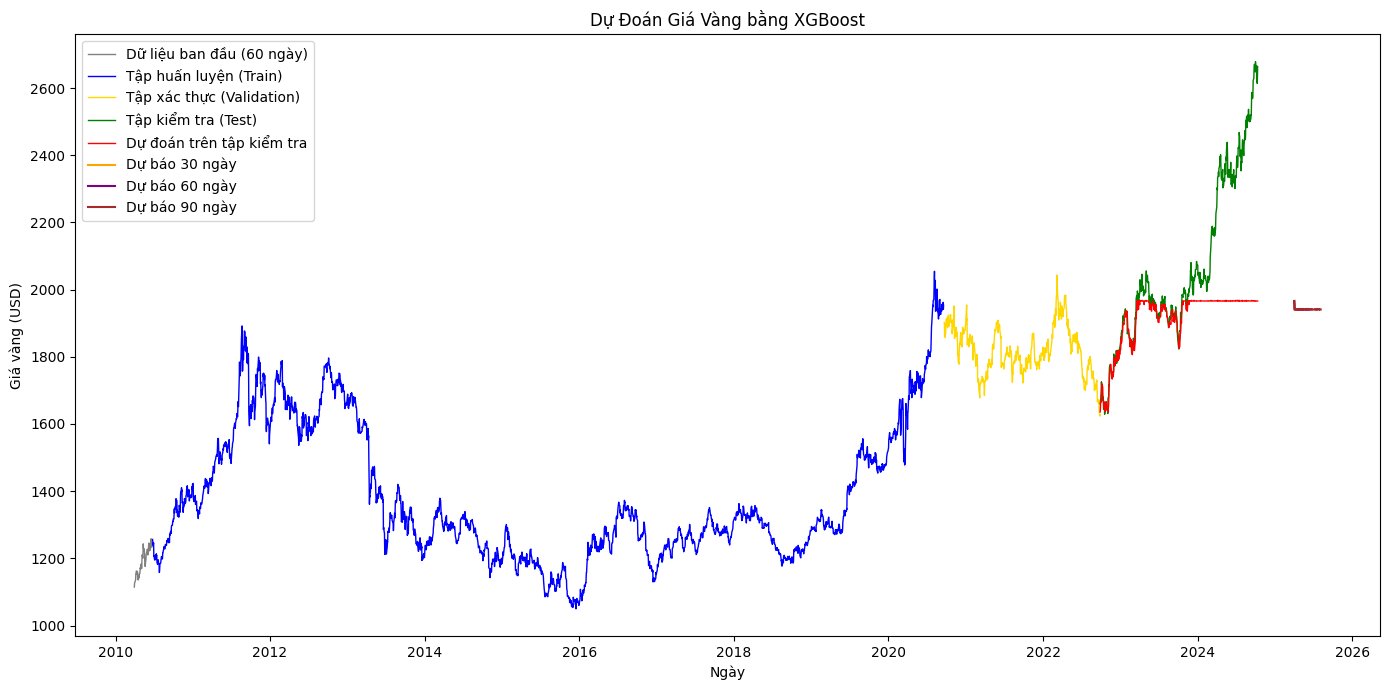

In [16]:
plt.figure(figsize=(14, 7))

plt.plot(date_for_plot[:timestep], inverse_scale(y[:timestep]), color='gray', label='Dữ liệu ban đầu (60 ngày)', linewidth=1)
plt.plot(date_for_plot[timestep:n_train], inverse_scale(y[timestep:n_train]), color='blue', label='Tập huấn luyện (Train)', linewidth=1)
plt.plot(date_for_plot[n_train:n_train+n_val], inverse_scale(y[n_train:n_train+n_val]), color='gold', label='Tập xác thực (Validation)', linewidth=1)
plt.plot(date_for_plot[n_train+n_val:n_train+n_val+n_test], inverse_scale(y[n_train+n_val:n_train+n_val+n_test]), color='green', label='Tập kiểm tra (Test)', linewidth=1)
plt.plot(date_for_plot[n_train+n_val:n_train+n_val+n_test], y_pred_orig, color='red', label='Dự đoán trên tập kiểm tra', linewidth=1)

# Multi-step forecast
future_dates = pd.date_range(date_full[-1] + pd.Timedelta(days=1), periods=90, freq='B')
plt.plot(future_dates[:30], forecast_30, color='orange', label='Dự báo 30 ngày', linewidth=1.5)
plt.plot(future_dates[:60], forecast_60, color='purple', label='Dự báo 60 ngày', linewidth=1.5)
plt.plot(future_dates[:90], forecast_90, color='brown', label='Dự báo 90 ngày', linewidth=1.5)

plt.title('Dự Đoán Giá Vàng bằng XGBoost')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng (USD)')
plt.legend()
plt.tight_layout()
plt.show()
